In [1]:
%config InlineBackend.figure_format = 'retina'

# Quantum Mechanical Data Assimilation

In [2]:
import math
import numpy as np

import matplotlib.pyplot as plt

import shelve


import L63
import QMDA

## Example: L63 dynamical system

We generate the test data for the data assimilation in an external script and not within this notebook due to the time it takes to compute the data-driven basis.


```python

import numpy

import shelve

import L63
import QMDA


T = (100, 100)
ΔT = 0.01

print('Compute L63-trajectory...')
x = numpy.array([-0.145, 0.096, 26.715])
X__ = L63.trajectory(numpy.array([x]), T=T[0]+T[1], dT=ΔT)[:,0,:]

Y__ = X__[:int(T[0]/ΔT),:]
print('Compute data-driven basis...')
φ, λ, _ = QMDA.data_driven_basis(Y__, L=100)

print('Save data...')
WS = shelve.open('L63-QMDA_T={0}+{1}'.format(T[0], T[1]))

try:
    WS['T'] = T
    WS['ΔT'] = ΔT
    WS['X__'] = X__

    WS['Y__'] = Y__

    WS['λ'] = λ
    WS['φ'] = φ

finally:
    WS.close()

print('Done.')
```


We generate a trajectory of the L63 dynamical system that has a length of $T = 100 + 100$ at time-intervals  
$\Delta T = 0.01$. The first half of the trajectory is then used to compute the data-driven basis.

The data is saved in a Python shelf with the following objects:

- `T`, a tuple indicating the length of the training and test trajectory in the first and second component respectively
- `ΔT`, the time resolution of the trajectory, i.e. the time between adjacent points in the trajectory
- `X__`, the entire trajectory
- `Y__`, the first part of the trajectory from which the data-driven basis is computed
- `λ`, the eigenvalues of the data-driven basis
- `φ`, the data-driven basis vectors

In [3]:
WS = shelve.open('data/L63-QMDA_T={0}+{1}'.format(100, 100), flag='r')

try:
    T = WS['T']
    ΔT = WS['ΔT']
    X__ = WS['X__']

    Y__ = WS['Y__']

    λ = WS['λ']
    φ = WS['φ']

finally:
    WS.close()



T__ = ΔT * np.arange(-int(T[0]/ΔT), int(T[1]/ΔT) + 1)
# \_ T__ : time-stamps of the trajectory X__


h = (lambda x: x[0])
# \_ h : observable
H__ = np.apply_along_axis(h, 1, X__)
# \_ H__ : evaluated observable h along the the trajectory X__


φ = φ / np.sqrt(np.diag(np.transpose(np.conjugate(φ)) @ φ) / φ.shape[0])

### Data-driven basis

When we plot the data-driven basis functions, we find that those do qualitatively resemble Laplace-Beltrami eigenfunctions on the L63 attractor.

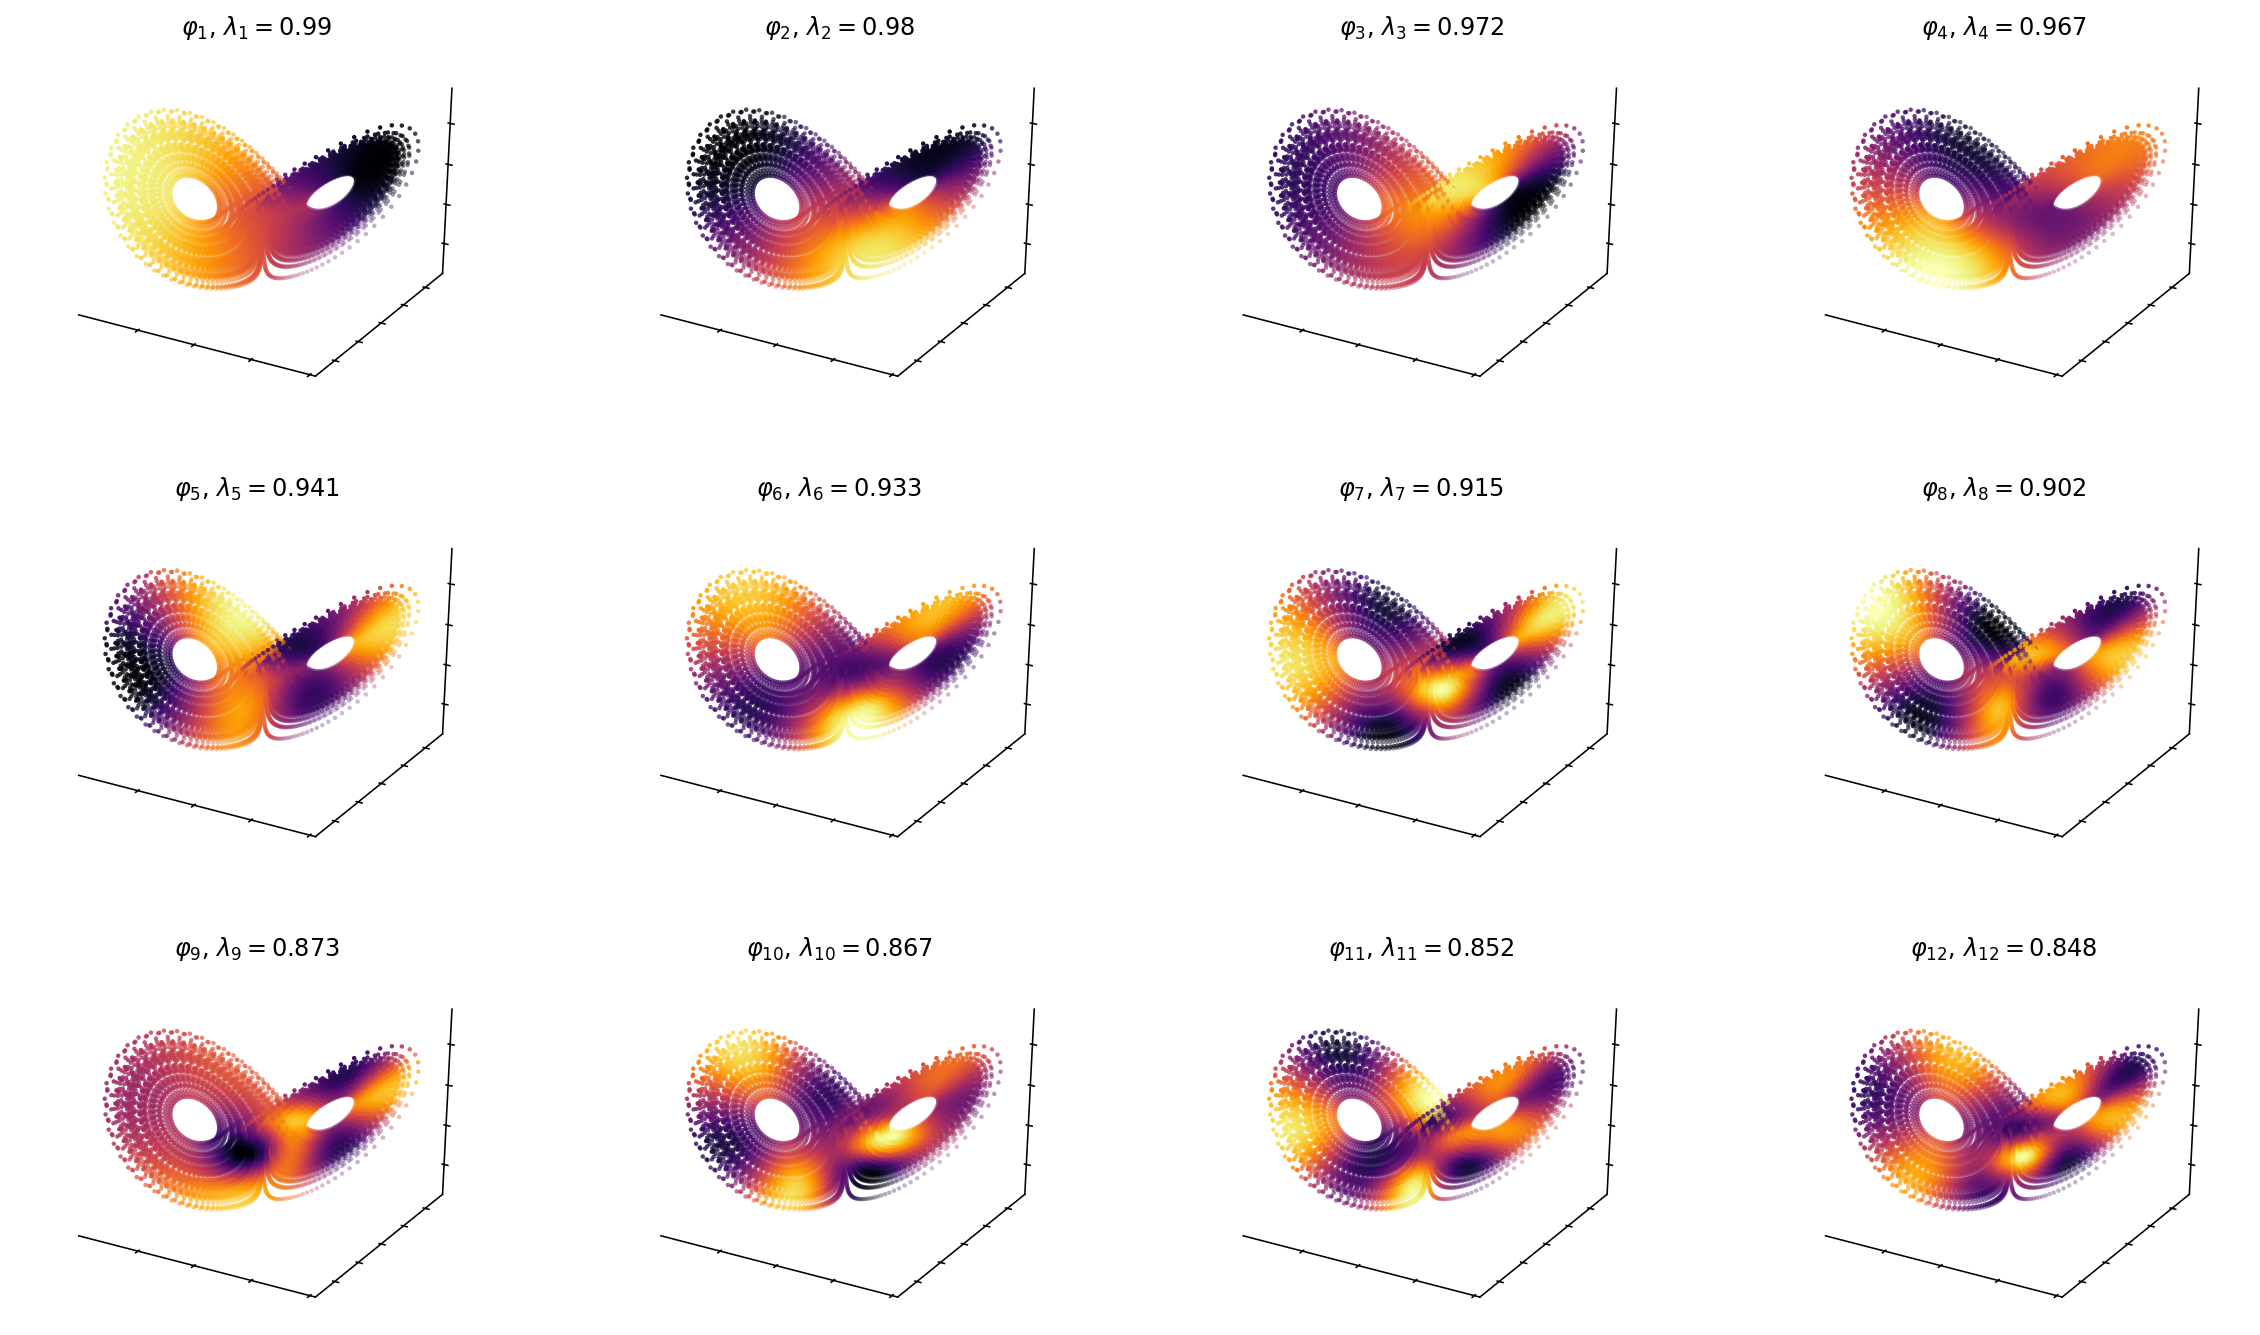

In [4]:
dim = (3,4)

_, ax = plt.subplots(dim[0], dim[1], subplot_kw={'projection': '3d'}, figsize=(dim[1]*5,dim[0]*4), dpi=72)


for i in range(dim[0]):
    for j in range(dim[1]):
        n = dim[1]*i+j

        if n+1 < φ.shape[1]:
            c_ = np.max(np.abs(φ[:,n+1]))

            L63.scatter_plot(Y__, h=φ[:,n+1], ax=ax[i,j], h_range=(-c_, c_), colormap='inferno')
            ax[i,j].set_title('$φ_{' + str(n+1) + '}$, $λ_{' + str(n+1) + '} = ' + str(round(λ[n+1], 3)) + '$')

In particular, we can reproduce Figure 4 of Giannakis (2019; Phys. Rev. E 100).

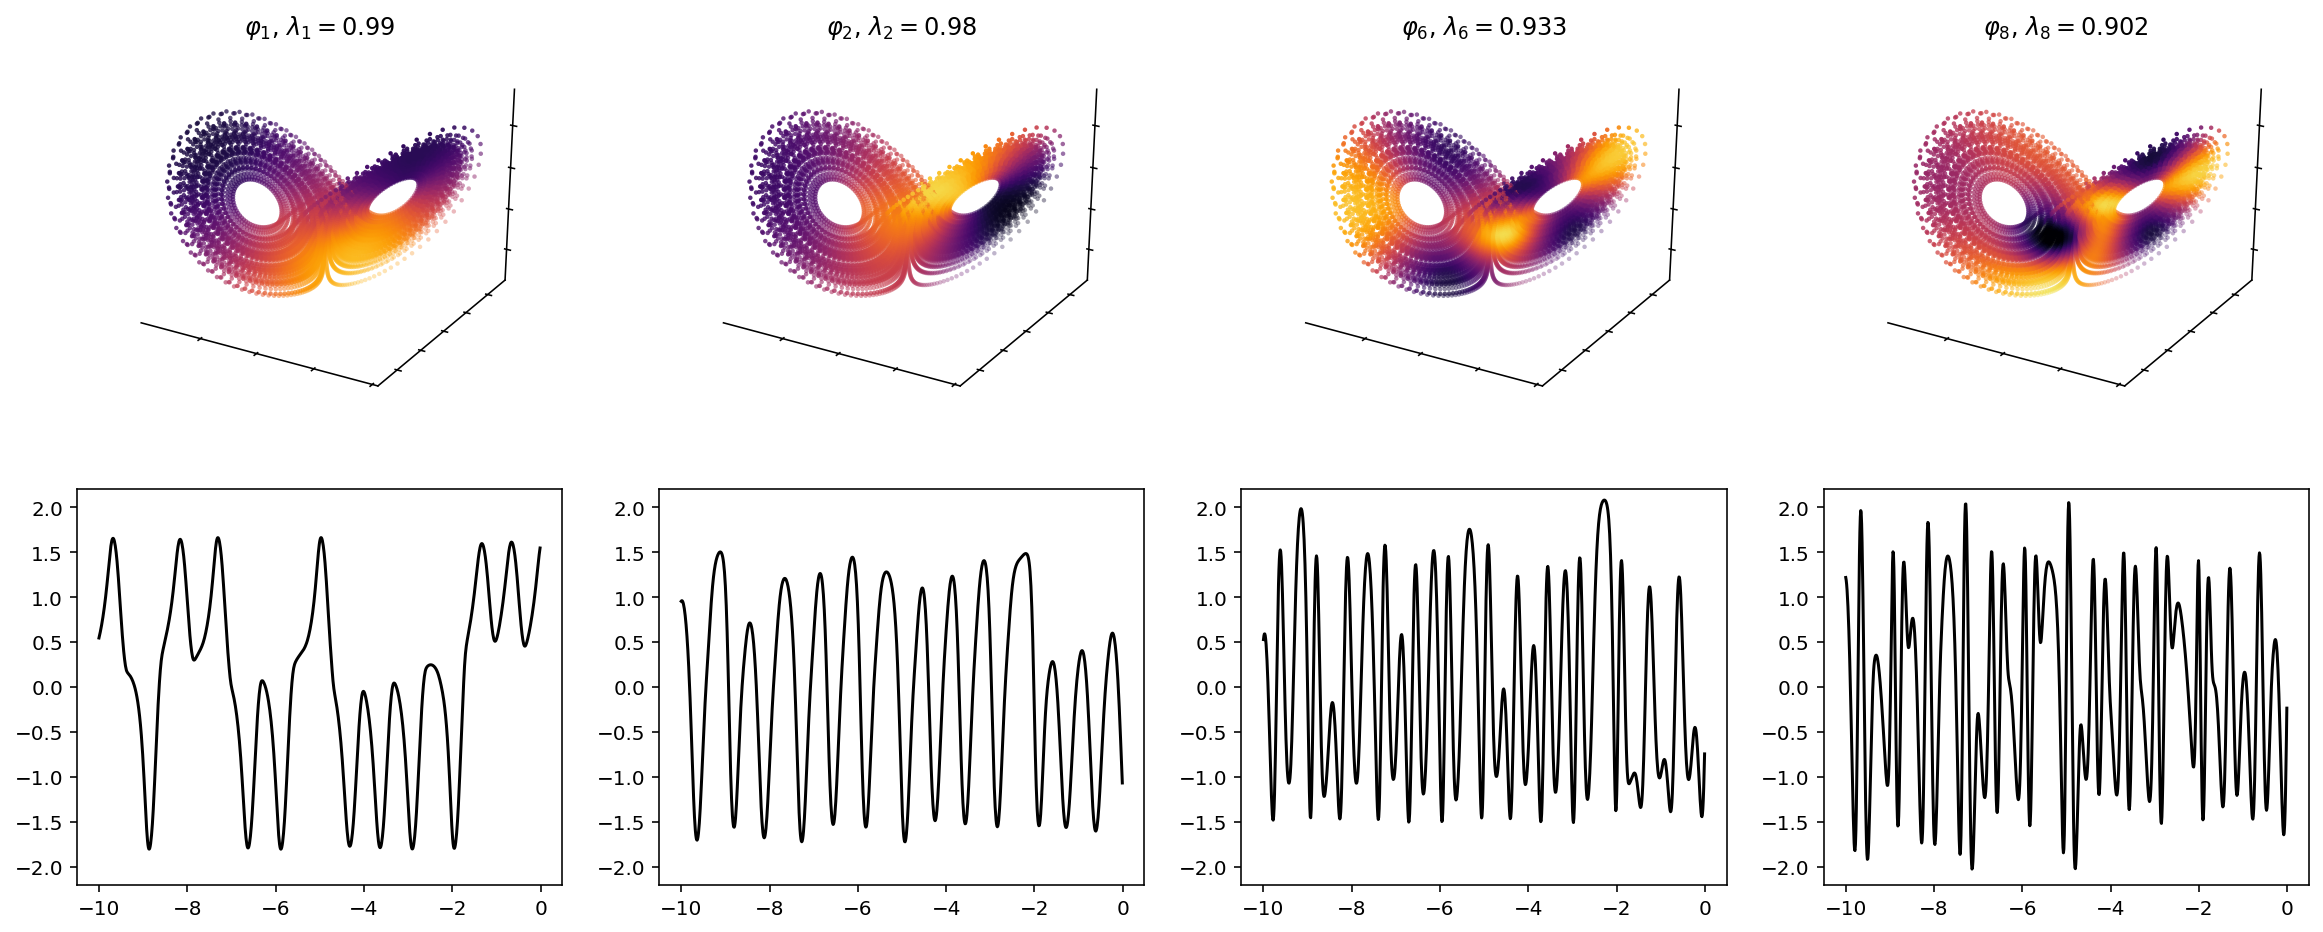

In [5]:
n__ = [1, 2, 6, 8]

fig, ax = plt.subplots(2, len(n__), subplot_kw={'projection': '3d'}, figsize=(len(n__)*5,2*4), dpi=72)


φ_range = (lambda c: (-c, c))(math.ceil(np.max(np.abs(φ[:,n__]))*10)/10+0.1)

for j in range(len(n__)):
    n = n__[j]

    if n < φ.shape[1]:
        L63.scatter_plot(Y__, h=φ[:,n+1], ax=ax[0,j], h_range=φ_range, colormap='inferno')
        ax[0,j].set_title('$φ_{' + str(n) + '}$, $λ_{' + str(n) + '} = ' + str(round(λ[n], 3)) + '$')

    ax[1,j].remove()
    ax[1,j] = fig.add_subplot(2, len(n__), len(n__)+1+j)

    ax[1,j].plot(T__[:len(φ[:,n])][-int(10/ΔT):], φ[-int(10/ΔT):,n], color='black')

    ax[1,j].set_ylim(φ_range)

### Koopman operator

Given the data-driven basis, we can finally compute the matrix-representations of the Koopman operators.

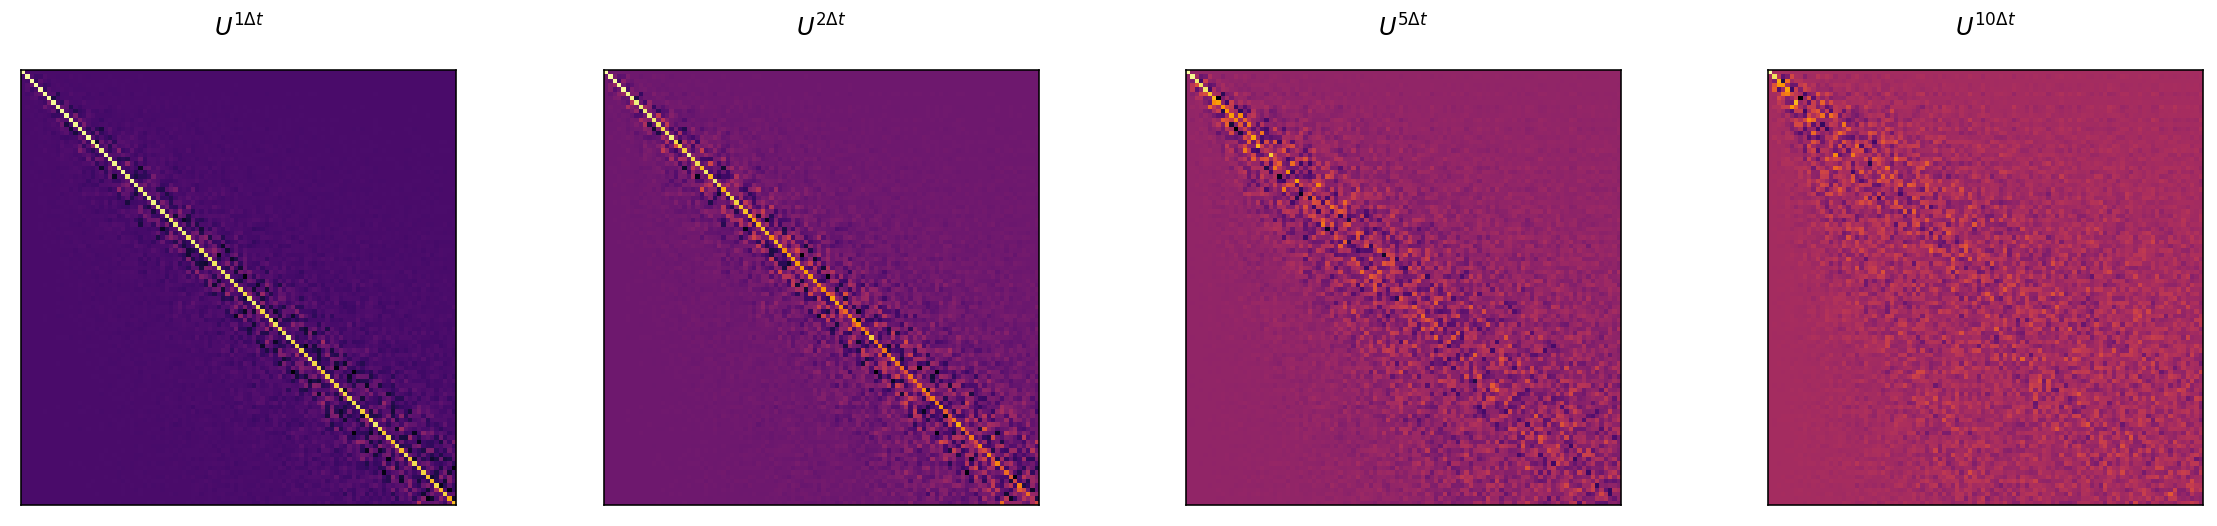

In [6]:
q = [1,2,5,10]

U = QMDA.koopman_operator(φ, q)


_, ax = plt.subplots(1, len(q), figsize=(len(q)*5,1*4), dpi=72)


for i in range(len(q)):
    ax[i].matshow(U[i,:,:], cmap='inferno')

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax[i].set_title('$U^{' + str(q[i]) + '\Delta t}$')

### Data assimilation

Finally, we can perform the data assimilation, where we incorporate incoming evidence every $τ = 1$ and reproduce Figure 5 of Giannakis (2019; Phys. Rev. E 100).

In [7]:
L = 16
N, _ = φ.shape

S = 32


τ = 0.5
q_τ = int(τ / ΔT)

U = QMDA.koopman_operator(φ[:,:L], shift_Q=np.arange(0, q_τ + 1, 1))
a, π, E = QMDA.observable_spectral_projectors(H__[np.where(T__ < 0)], φ[:,:L], S=S)


ρ0 = np.zeros((L, L))
ρ0[0,0] = 1





iT__ = np.where((0 <= T__) & (T__ <= 20))
P__ = np.empty((len(iT__[0]),S))


for t in range(P__.shape[0]):

    # > state-evolution
    q = t % q_τ

    ρ = np.transpose(np.conjugate(U[q])) @ ρ0 @ U[q]
    ρ = ρ / np.trace(ρ)

    # > state-collapse
    if t % q_τ == 0:
        a_ = H__[iT__][t]

        i = π(a_)
        
        ρ = np.transpose(np.conjugate(E[i,:,:])) @ ρ @ E[i,:,:]
        ρ = ρ / np.trace(ρ)

        ρ0 = ρ

    P__[t,:] = np.trace(E @ ρ, axis1=1, axis2=2)

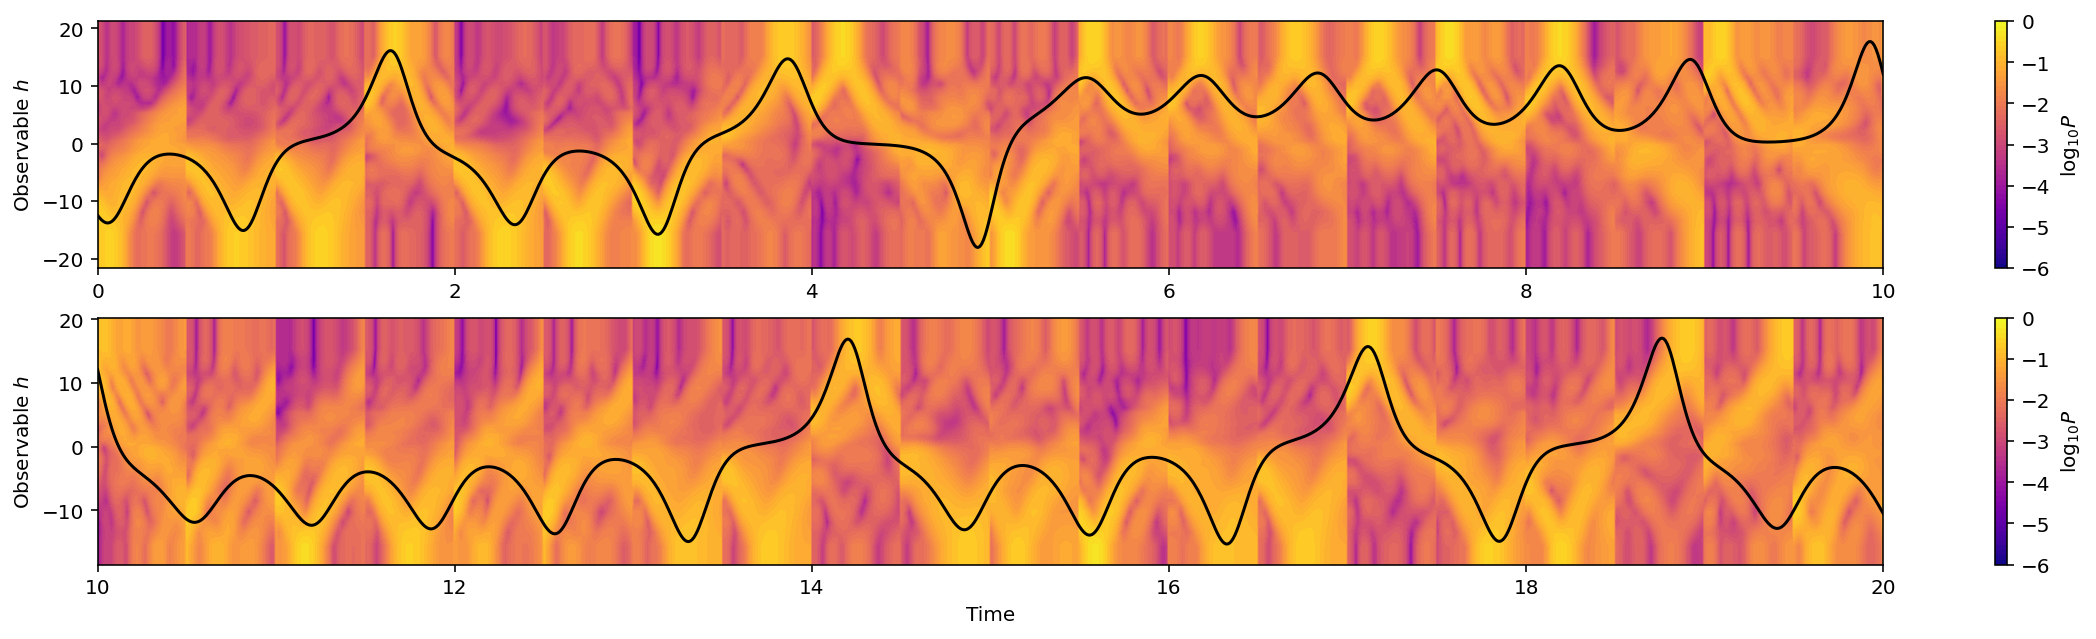

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(20, 2*2.5), dpi=72)

for i in range(2):

    h_map_X = T__[iT__]
    h_map_fX = H__[iT__]
    h_map_Y = np.hstack((a[0] - 0.5*np.ptp(a), a, a[-1] + 0.5*np.ptp(a)))
    h_map_Z = np.transpose(np.log10(np.hstack((P__[:,[0]], P__, P__[:,[-1]]))))

    h_map_fX_ = P__ @ a

    h_map_Z_lbound = int(np.floor(np.min(h_map_Z)))



    iT__i = np.where((i*10 <= T__[iT__]) & (T__[iT__] <= (i+1)*10))

    h_map_X = h_map_X[iT__i]
    h_map_fX = h_map_fX[iT__i]
    h_map_Z = np.squeeze(h_map_Z[:,iT__i])

    h_map_fX_ = h_map_fX_[iT__i]


    # ----------------------------------------------------------------------------------------------------


    cs = ax[i].contourf(h_map_X, h_map_Y, h_map_Z, np.linspace(h_map_Z_lbound,0,50+1), cmap='plasma')
    #for c in cs.collections:
    #    c.set_rasterized(True)

    cbar = fig.colorbar(cs, ax=ax[i])
    cbar.set_ticks(np.linspace(h_map_Z_lbound,0,abs(h_map_Z_lbound)+1))
    cbar.set_label('$\\mathrm{log}_{10} P$');

    ax[i].plot(h_map_X, h_map_fX, color='black')
    #ax[i].plot(h_map_X, h_map_fX_, color='black', linestyle=':')

    ax[i].set_ylim(np.min(h_map_fX) - 0.1*np.ptp(h_map_fX), np.max(h_map_fX) + 0.1*np.ptp(h_map_fX))

    if i == 2-1:
        ax[i].set_xlabel('Time');
    ax[i].set_ylabel('Observable $h$');

#fig.savefig('qmda.pdf', bbox_inches='tight')